## How to make stable ensemble in object detection

Hi everyone!

My name is Alex Shonenkov, I am DL/NLP/CV/TS research engineer. Especially I am in Love with NLP & DL.

Today I would like to share with you, my friends, super easy technique for bbox postprocessing and making ensemble in object detection tasks.

I spied this idea from really good russian competitions grandmaster Roman Solovyev [ZFTurbo](https://www.kaggle.com/zfturbo) in [this repository](https://github.com/ZFTurbo/Weighted-Boxes-Fusion) that I used in this kernel as [dataset](https://www.kaggle.com/shonenkov/weightedboxesfusion).

original paper: [Weighted Boxes Fusion: ensembling boxes for object detection models](https://arxiv.org/pdf/1910.13302.pdf)


![](https://i.ibb.co/681bjVr/2020-05-12-20-43-52.png)


## MAIN IDEA

We know about NMS (Non-maximum Suppression) method and
its [Soft-NMS extension](https://arxiv.org/pdf/1704.04503.pdf). But here we will use WBF (Weighted Boxes Fusion), that gives really good boost in [Open Images Dataset](https://storage.googleapis.com/openimages/web/index.html) according to [paper]((https://arxiv.org/pdf/1910.13302.pdf).

    
| Method | mAP(0.5) Result | Best params | Elapsed time (sec) | 
| ------ | --------------- | ----------- | ------------ |
| NMS | 0.5642 | IOU Thr: 0.5 | 47 |
| Soft-NMS | 0.5616 | Sigma: 0.1, Confidence Thr: 0.001 | 88 |
| NMW | 0.5667 | IOU Thr: 0.5 | 171 |
| **WBF** | **0.5982** | IOU Thr: 0.6 | 249 |
    


## Why WBF can be better than NMS or SoftNMS

Both NMS and Soft-NMS exclude some boxes, but WBF uses information from all boxes. It can fix some cases where
all boxes are predicted inaccurate by all models. NMS will leave only one inaccurate box, while WBF will fix it using information from all 3 boxes (see the example in Fig. 1, red predictions, blue ground truth).

<img src='https://i.ibb.co/d2P2pPL/2020-05-12-21-02-34.png' height=300 align="left"> 

In [1]:
!pip install --no-deps '../input/weightedboxesfusion/' > /dev/null

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from glob import glob
import torch
import cv2

In [3]:
%%time

marking = pd.read_csv('../input/global-wheat-detection/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

marking.head()

CPU times: user 855 ms, sys: 56.9 ms, total: 912 ms
Wall time: 928 ms


,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


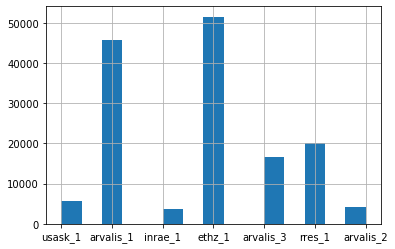

In [4]:
marking['source'].hist(bins=15);

## Stratify KFold

I think that main important factor for getting stable ensemble solution is using cross-validation with correct data splitting. It will help us to avoid overfitting solution. 

Below I would like to share with you my data split. I can't say that it is really correct way or not, but I believe it :)

- Stratify by source
- Stratify by count of bounding boxes

I would like to see stratified distribution on 5 folds

In [5]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

CPU times: user 476 ms, sys: 1.72 ms, total: 478 ms
Wall time: 488 ms


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [6]:
df_folds.head()

,bbox_count,source,stratify_group,fold
image_id,,,,
00333207f,55,arvalis_1,arvalis_1_3,1
005b0d8bb,20,usask_1,usask_1_1,3
006a994f7,25,inrae_1,inrae_1_1,1
00764ad5d,41,inrae_1,inrae_1_2,0
00b5fefed,25,arvalis_3,arvalis_3_1,3


## Prepare Dataset

For training folds for this kernel I have used [Pytorch Starter - FasterRCNN Train](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train) with 512x512 image size.

In [7]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [8]:
DATA_ROOT_PATH = '../input/global-wheat-detection/test'

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [9]:
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

## Load Pretrained Models

In [10]:
import gc
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator


def load_net(checkpoint_path):
    net = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
    num_classes = 2  # 1 class (wheat) + background
    # get number of input features for the classifier
    in_features = net.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    net.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint)
    net = net.cuda()
    net.eval()

    del checkpoint
    gc.collect()
    return net

models = [
    load_net('../input/wheat-fasterrcnn-folds/fold0-best1.bin'),
    load_net('../input/wheat-fasterrcnn-folds/fold1-best1.bin'),
    load_net('../input/wheat-fasterrcnn-folds/fold2-best1.bin'),
    load_net('../input/wheat-fasterrcnn-folds/fold3-best1.bin'),
    load_net('../input/wheat-fasterrcnn-folds/fold4-best1.bin'),
]

## WBF & Ensemble methods 

In [11]:
from ensemble_boxes import *

device = torch.device('cuda:0')

def make_ensemble_predictions(images):
    images = list(image.to(device) for image in images)    
    result = []
    for net in models:
        outputs = net(images)
        result.append(outputs)
    return result

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.55, skip_box_thr=0.7, weights=None):
    boxes = [prediction[image_index]['boxes'].data.cpu().numpy()/(image_size-1) for prediction in predictions]
    scores = [prediction[image_index]['scores'].data.cpu().numpy() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]) for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

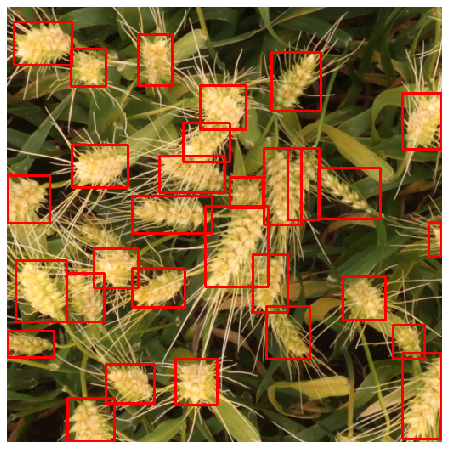

In [12]:
import matplotlib.pyplot as plt

for j, (images, image_ids) in enumerate(data_loader):
    if j > 0:
        break
predictions = make_ensemble_predictions(images)

i = 1
sample = images[i].permute(1,2,0).cpu().numpy()
boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample);

## Inference

In [13]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

In [14]:
results = []

for images, image_ids in data_loader:
    predictions = make_ensemble_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = (boxes*2).astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

## Submission

In [15]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head()

,image_id,PredictionString
0,2fd875eaa,0.9991 460 497 78 135 0.9984 106 584 138 85 0....
1,cc3532ff6,0.9986 771 827 165 158 0.9986 376 0 82 98 0.99...
2,51b3e36ab,0.9986 836 450 186 145 0.9982 234 644 93 155 0...
3,53f253011,0.9983 931 202 92 133 0.9973 233 840 114 93 0....
4,cb8d261a3,0.9973 21 864 78 143 0.9964 650 678 92 71 0.99...


## Thank you for reading my kernel!

So, I have demonstrated good technique for you, my friends! I hope you will make stable ensemble in this competition! :)



Just recently I have started publishing my works, if you like this format of notebooks I would like continue to make kernels.